# Step 1. 데이터 다운로드

아래 링크에서 korean-english-park.train.tar.gz 를 다운로드받아 한영 병렬 데이터를 확보합니다.

- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

from konlpy.tag import Mecab

print(tf.__version__)

2.4.1


## 데이터 로드

In [3]:
path_to_file_ko = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.ko'    
with open(path_to_file_ko, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(ko_raw))
print("Example:")

for sen in ko_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [4]:
path_to_file_en = os.getenv('HOME')+'/aiffel/s2s_translation/korean-english-park.train.en'
with open(path_to_file_en, "r") as f:
    en_raw = f.read().splitlines()
    
print("Data Size:", len(en_raw))
print("Example:")

for sen in en_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


---

# Step 2. 데이터 정제

1) set 데이터형이 __중복을 허용하지 않는다는 것을 활용__해 중복된 데이터를 제거하도록 합니다. 데이터의 __병렬 쌍이 흐트러지지 않게 주의__하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.

2) 앞서 정의한 preprocessing() 함수는 한글에 대해 동작하지 않습니다. __한글에 적용할 수 있는 정규식__을 추가하여 함수를 재정의하세요!

3) 타겟 언어인 영문엔 <start> 토큰과 <end> 토큰을 추가하고 split() 함수로 토큰화합니다. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. KoNLPy가 설치되어 있지 않다면 아래 문서를 참고해 설치해 주세요.

- [설치하기-KoNLPy](https://konlpy.org/ko/latest/install/#ubuntu)

모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다. cleaned_corpus로부터 토큰의 길이가 40 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축하세요.

## 데이터 중복 제거

In [5]:
cleaned_corpus = list(set(zip(ko_raw, en_raw)))
len(cleaned_corpus)

78968

## 데이터 정제

In [6]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,1-9\\s]", "", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    if s_token == False:
        sentence = mecab.morphs(sentence)
    else:
        sentence = sentence.split()
    
    return sentence

In [7]:
ko_corpus = []
en_corpus = []

for i in cleaned_corpus:
    ko_sentence = preprocess_sentence(i[0])
    en_sentence = preprocess_sentence(i[1], s_token = True, e_token = True)
    
    if len(ko_sentence) <= 40:
        ko_corpus.append(ko_sentence)
        en_corpus.append(en_sentence)

print("Korean:", ko_corpus[100])   # go away !
print("English:", en_corpus[100])   # <start> salga de aqu ! <end>

Korean: ['인도', '관계자', '들', '은', '이제', '21', '년', '뉴델리', '에서', '개최', '될', '영연방', '경기', '대회', '에', '집중', '하', '겠', '다고', '밝혔', '다', '.']
English: ['<start>', 'indian', 'officials', 'say', 'they', 'will', 'now', 'concentrate', 'on', 'the', '21', 'commonwealth', 'games', 'which', 'will', 'be', 'held', 'in', 'new', 'delhi', '.', '<end>']


In [8]:
print(len(ko_corpus))
print(len(en_corpus))

65287
65287


---

# Step 3. 데이터 토큰화

앞서 정의한 tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각각의 tokenizer를 얻으세요! 단어의 수는 실험을 통해 적당한 값을 맞춰주도록 합니다! (최소 10,000 이상!)

난이도에 비해 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않습니다.

In [9]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [10]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(ko_corpus)
dec_tensor, dec_tokenizer = tokenize(en_corpus)

print('Korean Vocab Size:', len(enc_tokenizer.index_word))
print('English Vocab size:', len(dec_tokenizer.index_word))

Korean Vocab Size: 46450
English Vocab size: 47665


---

# Step 4. 모델 설계

한국어를 영어로 잘 번역해 줄 멋진 __Attention 기반 Seq2seq 모델__을 설계하세요! 앞서 만든 모델에 Dropout 모듈을 추가하면 성능이 더 좋아질 거랍니다! Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다!

In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()

        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)

    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)

        return out

In [13]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [14]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1 # 예: len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1 # 예: len(dec_tokenizer.index_word) + 1

units         = 256
embedding_dim = 256

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 256)
Decoder Output: (64, 47666)
Decoder Hidden State: (64, 256)
Attention: (64, 30, 1)


---

# Step 5. 훈련하기

훈련엔 위에서 사용한 코드를 그대로 사용하되, eval_step() 부분이 없음에 유의합니다! 매 스텝 아래의 예문에 대한 번역을 생성하여 __본인이 생각하기에 가장 멋지게 번역한 Case를 제출__하세요! (Attention Map을 시각화해보는 것도 재밌을 거예요!)

참고: 데이터의 난이도가 높은 편이므로 생각만큼 결과가 잘 안나올 수 있습니다.

``` python
## 예문 ##
K1) 오바마는 대통령이다.
K2) 시민들은 도시 속에 산다.
K3) 커피는 필요 없다.
K4) 일곱 명의 사망자가 발생했다.

## 제출 ##
E1) obama is the president . <end>
E2) people are victims of the city . <end>
E2) the price is not enough . <end>
E2) seven people have died . <end>
```

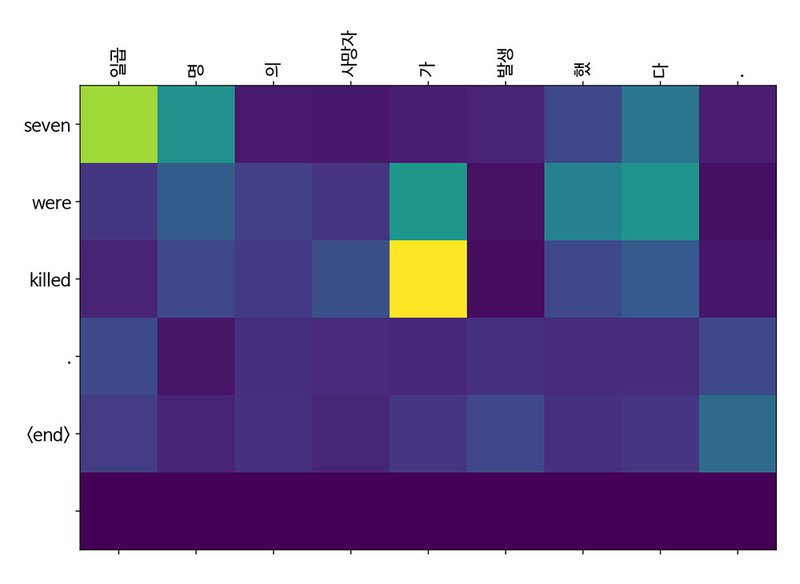

## Optimizer & Loss

In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## 모델 훈련

In [16]:
@tf.function    # 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:    # 학습하며 발생한 모든 연산을 기록
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]

        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)

    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [17]:
enc_train = enc_tensor
dec_train = dec_tensor

In [18]:
from tqdm import tqdm    # tqdm
import random

# Training Process

from tqdm import tqdm

EPOCHS = 50

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

Epoch 50: 100%|██████████| 1021/1021 [06:20<00:00,  2.68it/s, Loss 0.4060]


## 결과 시각화

In [19]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result), :len(sentence)]
    plot_attention(attention, str(sentence).split(), str(result).split(' '))

/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama has the president to stump today . <end> 


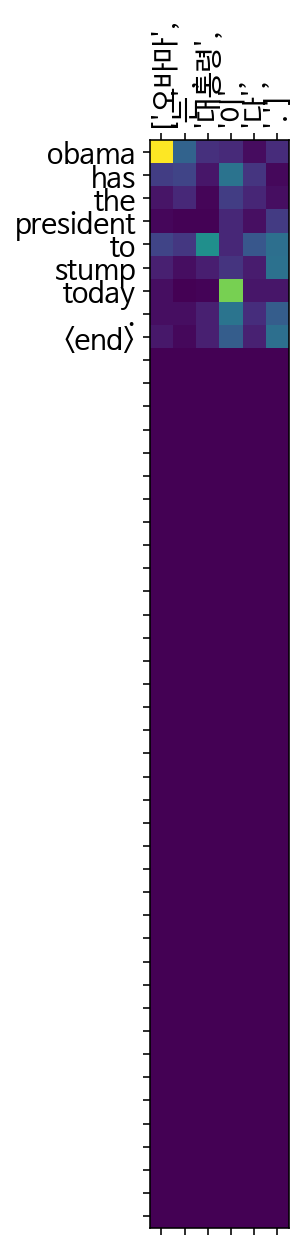

In [20]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: people are taking on recession . <end> 


/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


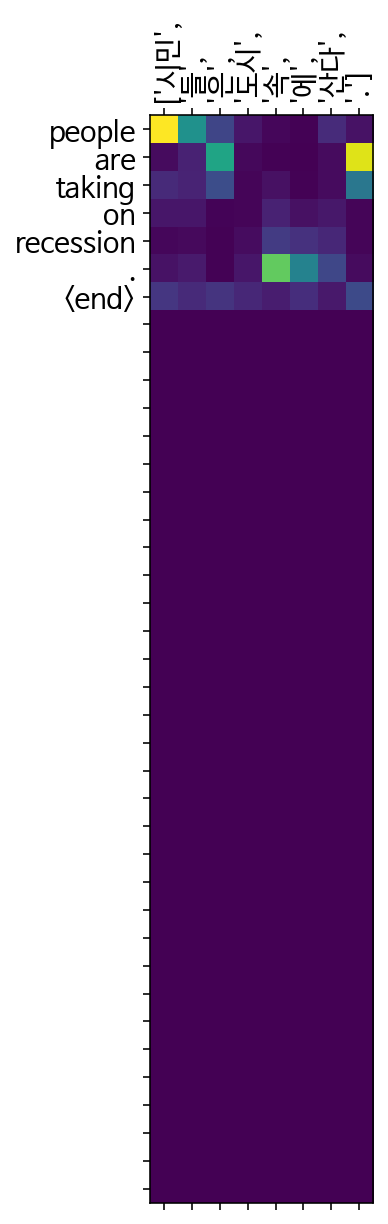

In [21]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: it never used the alcohol that can be used in the publishing . <end> 


/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


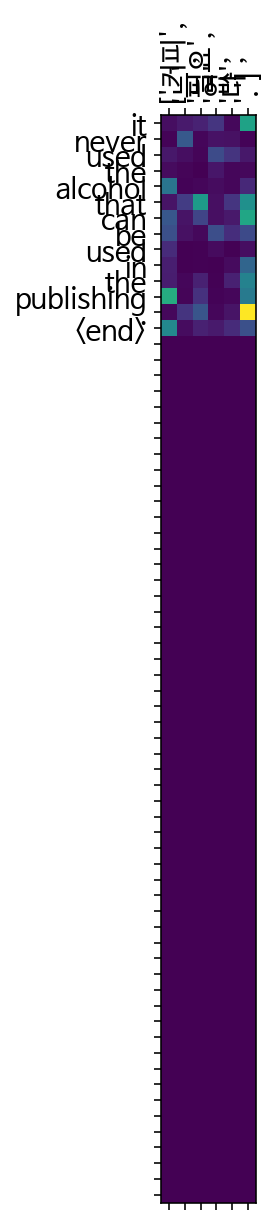

In [22]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: five people were also injured . <end> 


/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/aiffel-dj24/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


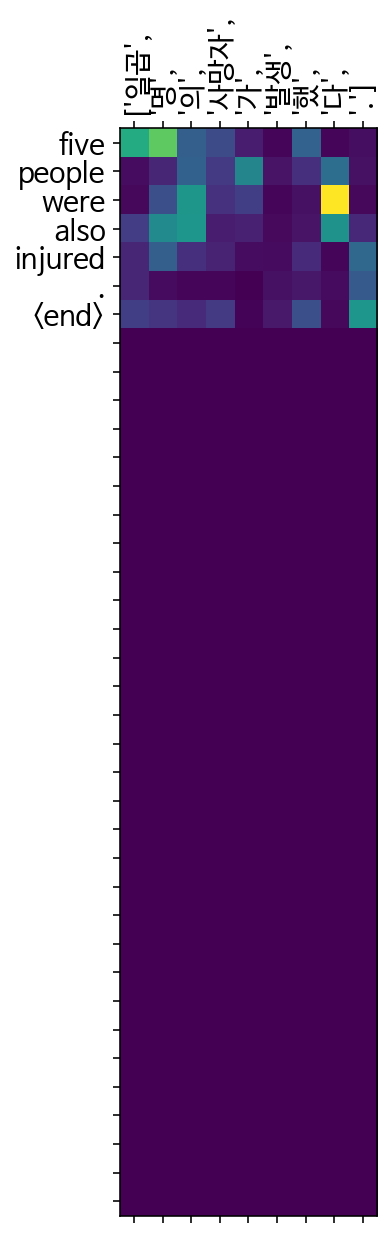

In [23]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

---

# 루브릭

__1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.__  

- 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.

__2. Attentional Seq2seq 모델이 정상적으로 구동된다.__  

- seq2seq 모델 훈련 과정에서 epoch 50회 진행 결과 training loss 2.0에서 0.4로 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.

__3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.__  

- 테스트 결과 의미는 있지만 주어진 문장에 대한 번역이라고 보기 힘든 문장이 나왔다.

---

# 회고

- 코드가 길다보니 어느 부분이 어떻게 작용하는지 코드 해석이 부족했다.
- 결과물이 적어도 비슷한 문장으로 번역될 줄 알았는데 상관없는 문장이 생성되어 아쉬웠다. 사실 어느 부분을 어떻게 수정해야 정확한 번역이 가능한지 아직도 잘 모르겠다.